## Imports

In [11]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import mlflow.pytorch
from edit_galaxy_loader import GalaxyDataset
import numpy as np
import h5py
from astropy.visualization import (MinMaxInterval, LogStretch, SqrtStretch,
                                   AsinhStretch, PowerStretch, ImageNormalize,
                                   ZScaleInterval, LinearStretch)
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import pandas as pd

## Helpers and Model/Data Loading

In [2]:
# ——————————————————————————————————————————————
# 1) Dataset / DataLoader
# ——————————————————————————————————————————————
dataset = GalaxyDataset(
     h5_path='/path/to/data',
    transform = None, normalize=True)

total_size = len(dataset)

# Define split sizes
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size  # Remaining 15%

g = torch.Generator().manual_seed(0)
_, _, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=g)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

# ——————————————————————————————————————————————
# 2) False‑color helper
# ——————————————————————————————————————————————
def generate_false_color_images(images: torch.Tensor) -> torch.Tensor:
    """
    images: (B, 5, H, W)
    returns: (B, H, W, 3) in [0,1]
    """
    red   = images[:, 2]   # i/z
    green = images[:, 1]   # r
    blue  = images[:, 0]   # g

    fc = torch.stack([red, green, blue], dim=-1)  # (B,H,W,3)
    for i in range(fc.shape[0]):
        img = fc[i]
        mn, mx = img.min(), img.max()
        if mx > mn:
            fc[i] = (img - mn) / (mx - mn)
        else:
            fc[i] = 0.0
    return fc

# Set up a helper function for plot scaling
def get_normalization(scaling, image):
    if scaling == "zscale":
        interval = ZScaleInterval()
        stretch = LinearStretch()
    elif scaling == "linear":
        interval = MinMaxInterval()
        stretch = LinearStretch()
    elif scaling == "log":
        interval = MinMaxInterval()
        stretch = LogStretch()
    elif scaling == "sqrt":
        interval = MinMaxInterval()
        stretch = SqrtStretch()
    elif scaling == "asinh":
        interval = MinMaxInterval()
        stretch = AsinhStretch()
    elif scaling == "power":
        interval = MinMaxInterval()
        stretch = PowerStretch(2)
    else:
        raise ValueError(f"Unknown scaling: {scaling}")
    return ImageNormalize(image, interval=interval, stretch=stretch)

# ——————————————————————————————————————————————
# 3) Instantiate & load your new model
# ——————————————————————————————————————————————
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set MLflow experiment or tracking URI if needed
mlflow.set_tracking_uri("http://localhost:8080")  # Change as needed
mlflow.set_experiment("model_name")  # Change to your experiment name

# Step 1: Query MLflow to find the best model run
client = mlflow.tracking.MlflowClient()
experiment = mlflow.get_experiment_by_name("model_name")

best_run = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="attributes.status = 'FINISHED'",
    order_by=["metrics.val_loss ASC"],  # or whatever metric you log
    max_results=1
)[0]
print(f"Loading model from MLflow run ID: {best_run.info.run_id}")

# Step 2: Load model using MLflow
model_uri = f"runs:/{best_run.info.run_id}/best_model"  # assumes you logged with `mlflow.pytorch.log_model`
mmae = mlflow.pytorch.load_model(model_uri)

Loading model from MLflow run ID: 7998cdb8b4d24dd1b4d297cb7436704a


## High Redshift Example

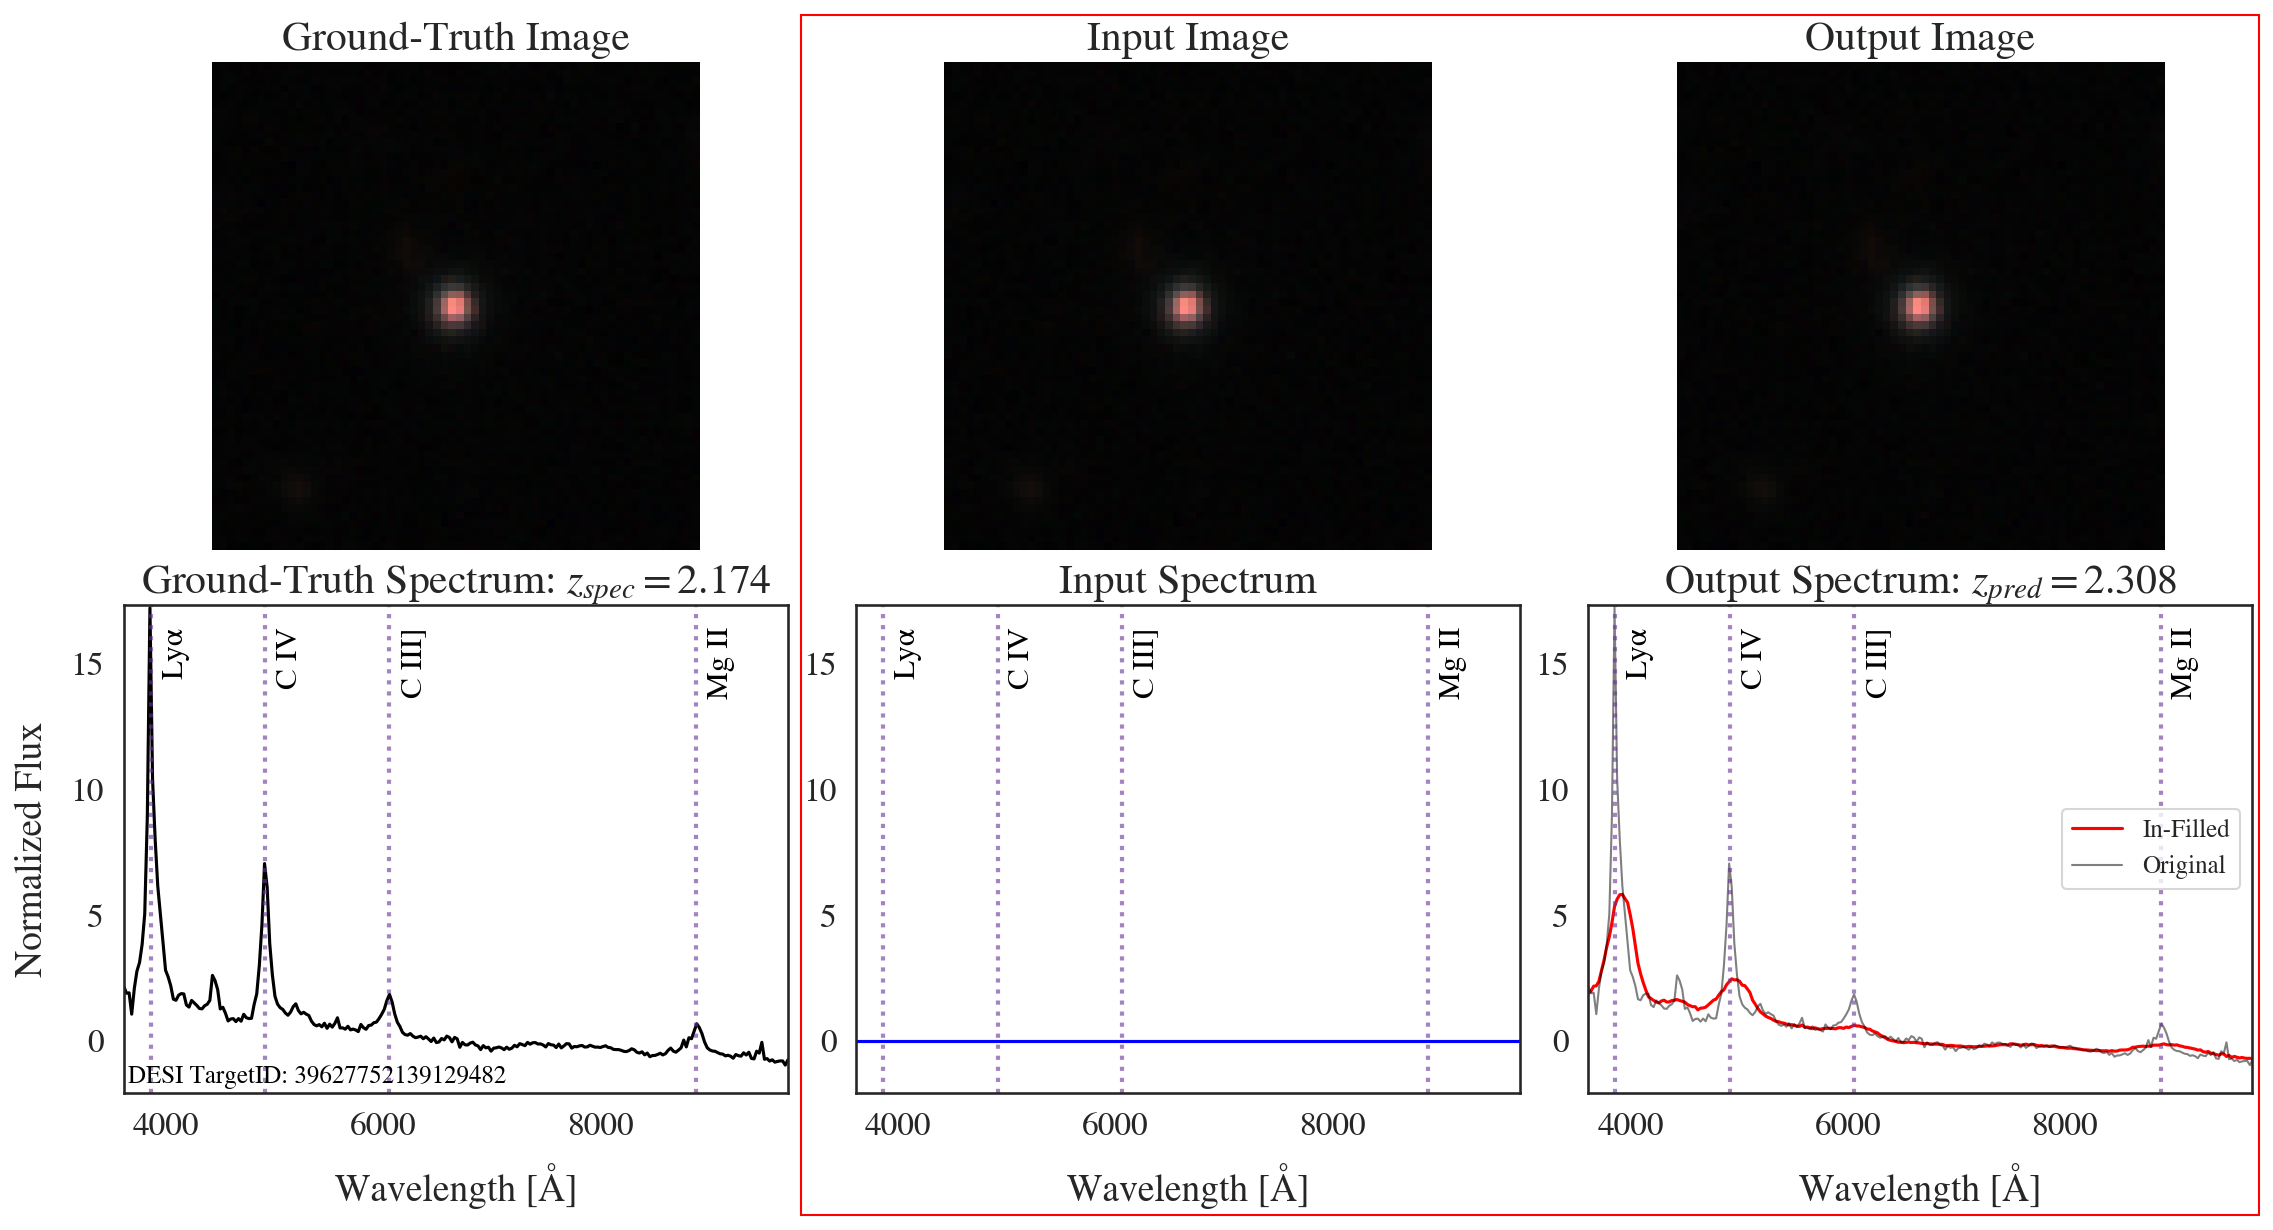

In [65]:
def visualize_reconstruction(
    model, dataloader, device="cuda",
    img_mask_ratio=0.05, spec_mask_ratio=0.5,
    source_idx=None, targetid=None,   # choose specific dataset index
    wave_file="/path/to/data", random_state=0
):

    # Aesthetic settings
    sns.set_theme(style="white")
    plt.rcParams.update({
        "font.size": 24,
        "axes.labelsize": 20,
        "axes.titlesize": 20,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 20,
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "font.family": "serif",
        "font.serif": ["STIXGeneral"],
        "mathtext.fontset": "stix"
    })
    
    model.eval()
    model.to(device)

    # Reproducibility - keep the masked portion the same
    torch.manual_seed(random_state)
    np.random.seed(0)

    with h5py.File(wave_file, "r") as f:
        wave = f["spectrum/wave"][0]

    # --------------------------
    # SELECT SPECIFIC SAMPLE
    # --------------------------
    dataset = dataloader.dataset

    if targetid is not None:
        # find the index of this targetid inside the dataset
        all_ids = [sample[3].item() if torch.is_tensor(sample[3]) else sample[3]
                   for sample in dataset]
        try:
            source_idx = all_ids.index(targetid)
        except ValueError:
            raise ValueError(f"TargetID {targetid} not found in dataset.")

    if source_idx is not None:
        sample = dataset[source_idx]

        if isinstance(sample, (list, tuple)):
            if len(sample) == 2:
                img, spec = sample
                redshift, targetid = None, None
            elif len(sample) == 3:
                img, spec, redshift = sample
                targetid = None
            elif len(sample) == 4:
                img, spec, redshift, targetid = sample
            else:
                raise ValueError(f"Unexpected dataset sample length {len(sample)}")
        else:
            raise TypeError(f"Unexpected sample type: {type(sample)}")

        emission_lines = {
            "Lyα": 1215.67,
            "C IV": 1549.0,
            "C III]": 1909.0,
            "Mg II": 2799.0,
        }
        
        if redshift is not None:
            obs_lines = {name: wl * (1 + redshift) for name, wl in emission_lines.items()}

        # Add batch dimension
        img = img.unsqueeze(0)
        spec = spec.unsqueeze(0)

    else:
        # fallback: just take first batch
        batch = next(iter(dataloader))
        if isinstance(batch, (list, tuple)):
            if len(batch) == 2:
                img, spec = batch
                redshift, targetid = None, None
            elif len(batch) == 3:
                img, spec, redshift = batch
                targetid = None
            elif len(batch) == 4:   # <-- your case
                img, spec, redshift, targetid = batch
            else:
                raise ValueError(f"Unexpected dataloader output length {len(batch)}")
        else:
            raise TypeError(f"Unexpected batch type: {type(batch)}")

    img, spec = img.to(device), spec.to(device)

    # reshape spectrum
    spec = spec.unsqueeze(1)  # (B,1,7783)
    spec = F.avg_pool1d(spec, kernel_size=30, stride=30)

    with torch.no_grad():
        outputs = model(
            img, spec,
            img_mask_ratio=img_mask_ratio,
            spec_mask_ratio=spec_mask_ratio
        )

    # Unpack model outputs (dict)
    img_recon = outputs["img_recon"]
    spec_recon = outputs["spec_recon"]
    img_mask = outputs["img_mask"]
    spec_mask = outputs["spec_mask"]

    z_pred = outputs.get("redshift_pred", None)
    if z_pred is not None:
        z_pred = z_pred.squeeze().detach().cpu().item()

    idx = 0  # always first element since we forced batch=1

    # ---- IMAGE HANDLING ----
    orig_img   = img[idx].cpu()
    recon_img  = img_recon[idx].cpu()
    img_mask   = img_mask[idx].cpu()
    spec_mask  = spec_mask[idx].cpu()

    orig_fc  = generate_false_color_images(orig_img.unsqueeze(0))[0]
    recon_fc = generate_false_color_images(recon_img.unsqueeze(0))[0]

    H = model.img_size // model.patch_size
    patch_mask = img_mask.reshape(H, H)
    mask_vis   = torch.zeros_like(orig_fc)
    for i in range(H):
        for j in range(H):
            if patch_mask[i,j]:
                hs, he = i*model.patch_size, (i+1)*model.patch_size
                ws, we = j*model.patch_size, (j+1)*model.patch_size
                mask_vis[hs:he, ws:we, :] = 1.0

    masked_img    = orig_fc.clone()
    masked_img[mask_vis.bool()] = 0.5
    in_filled_img = orig_fc.clone()
    in_filled_img[mask_vis.bool()] = recon_fc[mask_vis.bool()]

    # ---- SPECTRUM HANDLING ----
    orig_spec = spec[idx].cpu().squeeze()
    L_trunc    = model.spec_num_patches * model.spectrum_patch_size
    orig_trunc = orig_spec[:L_trunc]
    recon_trunc= spec_recon[idx].cpu()[:L_trunc]
    spec_mask_pt = spec_mask.repeat_interleave(model.spectrum_patch_size)[:L_trunc]

    masked_spec    = orig_trunc.clone()
    masked_spec[spec_mask_pt.bool()]    = 0.0
    in_filled_spec = orig_trunc.clone()
    in_filled_spec[spec_mask_pt.bool()] = recon_trunc[spec_mask_pt.bool()]

    wave_tensor = torch.tensor(wave, dtype=spec.dtype, device=spec.device).unsqueeze(0).unsqueeze(0)
    wave_ds = F.avg_pool1d(wave_tensor, kernel_size=30, stride=30).cpu().squeeze(0).squeeze(0)
    wave_trunc = wave_ds[:L_trunc]

    # ---- PLOTTING ----
    scaling = "log"
    norm = get_normalization(scaling, orig_fc.numpy())
    
    fig, axs = plt.subplots(2,3,figsize=(15,8), constrained_layout=True)

    axs[0,0].imshow(orig_fc.numpy(), norm=norm)
    axs[0,0].set_title("Ground-Truth Image", fontsize=20)
    axs[0,0].axis("off")

    axs[0,1].imshow(masked_img.numpy())
    axs[0,1].set_title("Input Image", fontsize=20)
    axs[0,1].axis("off")

    axs[0,2].imshow(in_filled_img.numpy())
    axs[0,2].set_title("Output Image", fontsize=20)
    axs[0,2].axis("off")

    axs[1,0].plot(wave_trunc.numpy(), orig_trunc.numpy(), color="black")
    axs[1,0].set_title(rf"Ground-Truth Spectrum: $z_{{spec}}={redshift:.3f}$", fontsize=20)

    axs[1,1].plot(wave_trunc.numpy(), masked_spec.numpy(), color="blue")
    axs[1,1].set_title("Input Spectrum", fontsize=20)

    axs[1,2].plot(wave_trunc.numpy(), in_filled_spec.numpy(), color="red", label='In-Filled')
    axs[1,2].plot(wave_trunc.numpy(), orig_trunc.numpy(), color="black", alpha=0.5, linewidth=1, label='Original')
    axs[1,2].set_title(rf"Output Spectrum: $z_{{pred}}={z_pred:.3f}$", fontsize=20)
    axs[1,2].legend(fontsize=12, loc="center right")

    epsilon = 0.1
    ymin = min(orig_trunc.min().item(), masked_spec.min().item(), in_filled_spec.min().item()) - epsilon
    ymax = max(orig_trunc.max().item(), masked_spec.max().item(), in_filled_spec.max().item()) + epsilon
    for ax in [axs[1,0], axs[1,1], axs[1,2]]:
        ax.set_ylim(ymin - 1, ymax)
        ax.set_xlim(min(wave_trunc.numpy()), max(wave_trunc.numpy()))
        ax.set_xlabel("Wavelength [Å]", fontsize=18, labelpad=10)
    axs[1,0].set_ylabel("Normalized Flux", fontsize=18, labelpad=10)

    if redshift is not None:
        for name, wl_obs in obs_lines.items():
            for ax in [axs[1,0], axs[1,1], axs[1,2]]:
                offset = 100.0
                ax.axvline(wl_obs, color="rebeccapurple", linestyle=":", alpha=0.6, linewidth=2)
                ax.text(
                    wl_obs + offset, 
                    ymax * 0.95,              
                    name, 
                    rotation=90, 
                    va="top", ha="left",    
                    fontsize=15, 
                    color="black"
                )

    title = f"DESI TargetID: {targetid}" if targetid is not None else "Source"
    if redshift is not None:
        title += f"\n$z_{{\\mathrm{{spec}}}}$={redshift:.3f}"
    if z_pred is not None:
        title += f",  $z_{{\\mathrm{{pred}}}}$={z_pred:.3f} \n"

    if targetid is not None:
        fig.text(0.053, 0.115, f"DESI TargetID: {targetid}",
                 va="center", ha="left", fontsize=12, color='black')

    # Get bounding boxes of the 4 axes we want to enclose
    ax_list = [axs[0,1], axs[0,2], axs[1,1], axs[1,2]]
    bboxes = [ax.get_position() for ax in ax_list]
    
    # Padding (fraction of figure width/height)
    pad_x = 0.03
    pad_y = 0.03
    
    # Expand box with padding
    x0 = 0.352
    y0 = 0
    x1 = 1.0
    y1 = 1.0
    
    rect = patches.Rectangle(
        (x0, y0), x1 - x0, y1 - y0,
        transform=fig.transFigure,
        fill=False, color="red", linewidth=1
    )
    fig.patches.append(rect)


    #plt.tight_layout()
    plt.savefig('/save/fig/location')
    plt.show()

# The specific source being plotted here has this index and random state
indices = [1749]
randomstate=[9]

for j in randomstate:
    for i in indices:
        visualize_reconstruction(
        model=mmae,
        dataloader=test_loader,
        device=device,
        img_mask_ratio=0,
        spec_mask_ratio=1,
        source_idx=i, # pick specific source from dataset
        random_state=j
        )

## Low Redshift Example

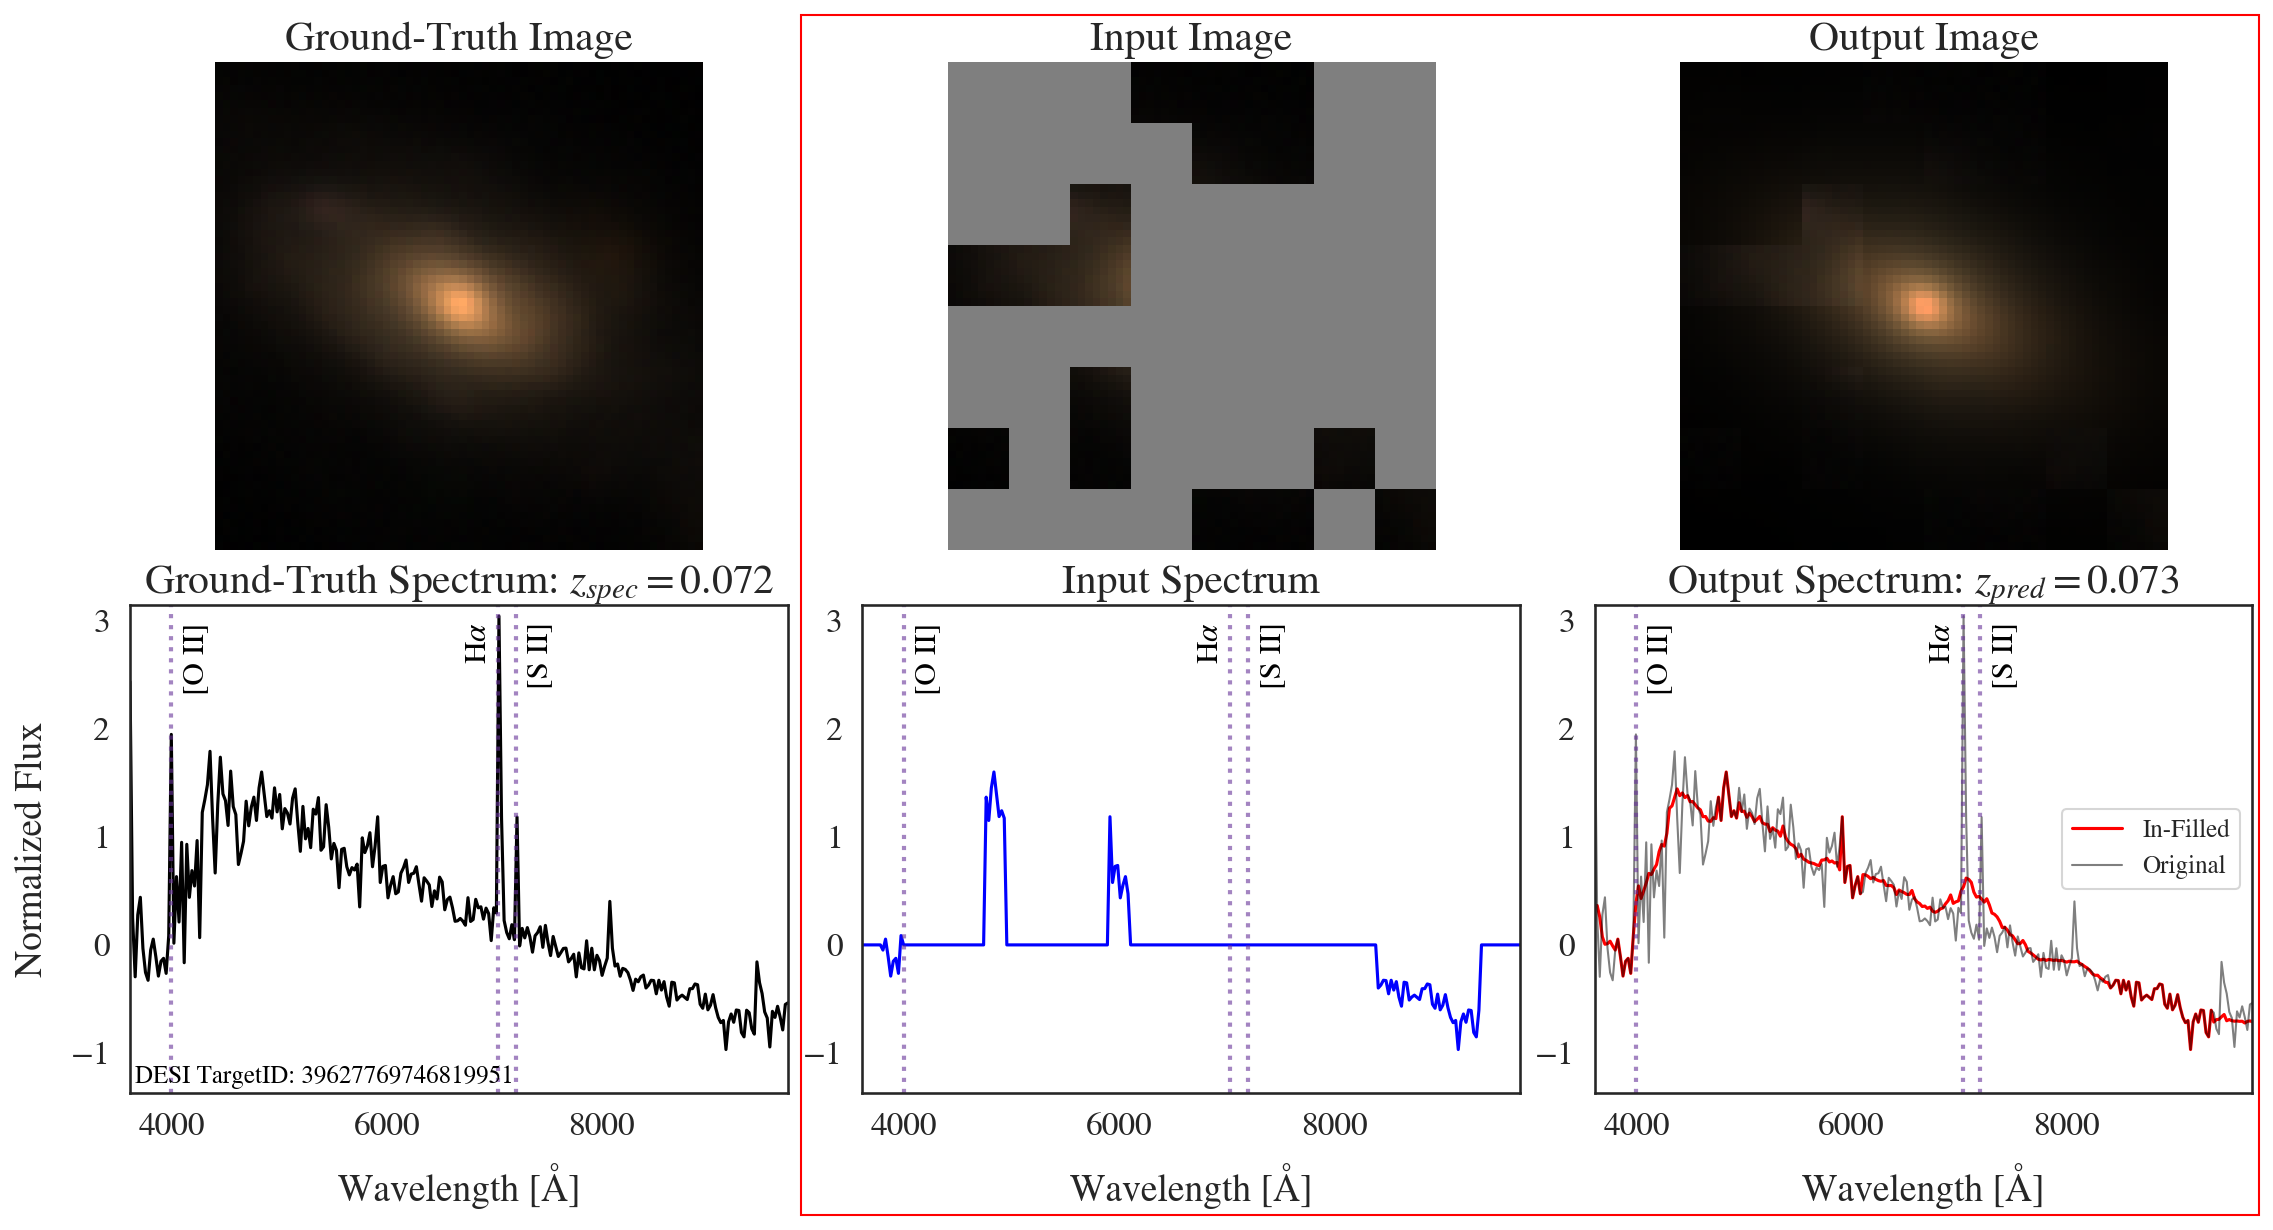

In [66]:
def visualize_reconstruction(
    model, dataloader, device="cuda",
    img_mask_ratio=0.05, spec_mask_ratio=0.5,
    source_idx=None, targetid=None,   # choose specific dataset index
    wave_file="/path/to/data", random_state=0
):

    # Aesthetic settings
    sns.set_theme(style="white")
    plt.rcParams.update({
        "font.size": 24,
        "axes.labelsize": 20,
        "axes.titlesize": 20,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 20,
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "font.family": "serif",
        "font.serif": ["STIXGeneral"],
        "mathtext.fontset": "stix"
    })
    
    model.eval()
    model.to(device)

    # Reproducibility - keep the masked portion the same
    torch.manual_seed(random_state)
    np.random.seed(0)

    with h5py.File(wave_file, "r") as f:
        wave = f["spectrum/wave"][0]

    # --------------------------
    # SELECT SPECIFIC SAMPLE
    # --------------------------
    dataset = dataloader.dataset

    if targetid is not None:
        # find the index of this targetid inside the dataset
        all_ids = [sample[3].item() if torch.is_tensor(sample[3]) else sample[3]
                   for sample in dataset]
        try:
            source_idx = all_ids.index(targetid)
        except ValueError:
            raise ValueError(f"TargetID {targetid} not found in dataset.")

    if source_idx is not None:
        sample = dataset[source_idx]

        if isinstance(sample, (list, tuple)):
            if len(sample) == 2:
                img, spec = sample
                redshift, targetid = None, None
            elif len(sample) == 3:
                img, spec, redshift = sample
                targetid = None
            elif len(sample) == 4:
                img, spec, redshift, targetid = sample
            else:
                raise ValueError(f"Unexpected dataset sample length {len(sample)}")
        else:
            raise TypeError(f"Unexpected sample type: {type(sample)}")

        emission_lines = {
            r"[O II]": 3727,
            r"H$\alpha$": 6563,
            r"[S II]": 6717,
        }
        
        if redshift is not None:
            obs_lines = {name: wl * (1 + redshift) for name, wl in emission_lines.items()}

        # Add batch dimension
        img = img.unsqueeze(0)
        spec = spec.unsqueeze(0)

    else:
        # fallback: just take first batch
        batch = next(iter(dataloader))
        if isinstance(batch, (list, tuple)):
            if len(batch) == 2:
                img, spec = batch
                redshift, targetid = None, None
            elif len(batch) == 3:
                img, spec, redshift = batch
                targetid = None
            elif len(batch) == 4:   # <-- your case
                img, spec, redshift, targetid = batch
            else:
                raise ValueError(f"Unexpected dataloader output length {len(batch)}")
        else:
            raise TypeError(f"Unexpected batch type: {type(batch)}")

    img, spec = img.to(device), spec.to(device)

    # reshape spectrum
    spec = spec.unsqueeze(1)  # (B,1,7783)
    spec = F.avg_pool1d(spec, kernel_size=30, stride=30)

    with torch.no_grad():
        outputs = model(
            img, spec,
            img_mask_ratio=img_mask_ratio,
            spec_mask_ratio=spec_mask_ratio
        )

    # Unpack model outputs (dict)
    img_recon = outputs["img_recon"]
    spec_recon = outputs["spec_recon"]
    img_mask = outputs["img_mask"]
    spec_mask = outputs["spec_mask"]

    z_pred = outputs.get("redshift_pred", None)
    if z_pred is not None:
        z_pred = z_pred.squeeze().detach().cpu().item()

    idx = 0  # always first element since we forced batch=1

    # ---- IMAGE HANDLING ----
    orig_img   = img[idx].cpu()
    recon_img  = img_recon[idx].cpu()
    img_mask   = img_mask[idx].cpu()
    spec_mask  = spec_mask[idx].cpu()

    orig_fc  = generate_false_color_images(orig_img.unsqueeze(0))[0]
    recon_fc = generate_false_color_images(recon_img.unsqueeze(0))[0]

    H = model.img_size // model.patch_size
    patch_mask = img_mask.reshape(H, H)
    mask_vis   = torch.zeros_like(orig_fc)
    for i in range(H):
        for j in range(H):
            if patch_mask[i,j]:
                hs, he = i*model.patch_size, (i+1)*model.patch_size
                ws, we = j*model.patch_size, (j+1)*model.patch_size
                mask_vis[hs:he, ws:we, :] = 1.0

    masked_img    = orig_fc.clone()
    masked_img[mask_vis.bool()] = 0.5
    in_filled_img = orig_fc.clone()
    in_filled_img[mask_vis.bool()] = recon_fc[mask_vis.bool()]

    # ---- SPECTRUM HANDLING ----
    orig_spec = spec[idx].cpu().squeeze()
    L_trunc    = model.spec_num_patches * model.spectrum_patch_size
    orig_trunc = orig_spec[:L_trunc]
    recon_trunc= spec_recon[idx].cpu()[:L_trunc]
    spec_mask_pt = spec_mask.repeat_interleave(model.spectrum_patch_size)[:L_trunc]

    masked_spec    = orig_trunc.clone()
    masked_spec[spec_mask_pt.bool()]    = 0.0
    in_filled_spec = orig_trunc.clone()
    in_filled_spec[spec_mask_pt.bool()] = recon_trunc[spec_mask_pt.bool()]

    wave_tensor = torch.tensor(wave, dtype=spec.dtype, device=spec.device).unsqueeze(0).unsqueeze(0)
    wave_ds = F.avg_pool1d(wave_tensor, kernel_size=30, stride=30).cpu().squeeze(0).squeeze(0)
    wave_trunc = wave_ds[:L_trunc]

    # ---- PLOTTING ----
    scaling = "log"
    norm = get_normalization(scaling, orig_fc.numpy())
    
    fig, axs = plt.subplots(2,3,figsize=(15,8), constrained_layout=True)

    axs[0,0].imshow(orig_fc.numpy(), norm=norm)
    axs[0,0].set_title("Ground-Truth Image", fontsize=20)
    axs[0,0].axis("off")

    axs[0,1].imshow(masked_img.numpy())
    axs[0,1].set_title("Input Image", fontsize=20)
    axs[0,1].axis("off")

    axs[0,2].imshow(in_filled_img.numpy())
    axs[0,2].set_title("Output Image", fontsize=20)
    axs[0,2].axis("off")

    axs[1,0].plot(wave_trunc.numpy(), orig_trunc.numpy(), color="black")
    axs[1,0].set_title(rf"Ground-Truth Spectrum: $z_{{spec}}={redshift:.3f}$", fontsize=20)

    axs[1,1].plot(wave_trunc.numpy(), masked_spec.numpy(), color="blue")
    axs[1,1].set_title("Input Spectrum", fontsize=20)

    axs[1,2].plot(wave_trunc.numpy(), in_filled_spec.numpy(), color="red", label='In-Filled')
    axs[1,2].plot(wave_trunc.numpy(), orig_trunc.numpy(), color="black", alpha=0.5, linewidth=1, label='Original')
    axs[1,2].set_title(rf"Output Spectrum: $z_{{pred}}={z_pred:.3f}$", fontsize=20)
    axs[1,2].legend(fontsize=12, loc="center right")

    epsilon = 0.1
    ymin = min(orig_trunc.min().item(), masked_spec.min().item(), in_filled_spec.min().item()) - epsilon
    ymax = max(orig_trunc.max().item(), masked_spec.max().item(), in_filled_spec.max().item()) + epsilon
    for ax in [axs[1,0], axs[1,1], axs[1,2]]:
        ax.set_ylim(ymin - 0.3, ymax)
        ax.set_xlim(min(wave_trunc.numpy()), max(wave_trunc.numpy()))
        ax.set_xlabel("Wavelength [Å]", fontsize=18, labelpad=10)
    axs[1,0].set_ylabel("Normalized Flux", fontsize=18, labelpad=10)

    if redshift is not None:
        for name, wl_obs in obs_lines.items():
            for ax in [axs[1,0], axs[1,1], axs[1,2]]:
                if name == r"H$\alpha$":
                    ax.axvline(wl_obs, color="rebeccapurple", linestyle=":", alpha=0.6, linewidth=2)
                    ax.text(
                        wl_obs - 50,
                        ymax * 0.95,
                        name,
                        rotation=90,
                        va="top", ha="right",   # align to the left of the line
                        fontsize=15,
                        color="black"
                        )
                else:  # all other lines
                    offset = 100.0
                    ax.axvline(wl_obs, color="rebeccapurple", linestyle=":", alpha=0.6, linewidth=2)
                    ax.text(
                        wl_obs + offset, 
                        ymax * 0.95,              # put text a bit below the top
                        name, 
                        rotation=90, 
                        va="top", ha="left",      # align text neatly
                        fontsize=15, 
                        color="black"
                        )

    title = f"DESI TargetID: {targetid}" if targetid is not None else "Source"
    if redshift is not None:
        title += f"\n$z_{{\\mathrm{{spec}}}}$={redshift:.3f}"
    if z_pred is not None:
        title += f",  $z_{{\\mathrm{{pred}}}}$={z_pred:.3f} \n"

    if targetid is not None:
        fig.text(0.056, 0.115, f"DESI TargetID: {targetid}",
                 va="center", ha="left", fontsize=12, color='black')

    # Get bounding boxes of the 4 axes we want to enclose
    ax_list = [axs[0,1], axs[0,2], axs[1,1], axs[1,2]]
    bboxes = [ax.get_position() for ax in ax_list]
    
    # Padding (fraction of figure width/height)
    pad_x = 0.03
    pad_y = 0.03
    
    # Expand box with padding
    x0 = 0.352
    y0 = 0
    x1 = 1.0
    y1 = 1.0
    
    rect = patches.Rectangle(
        (x0, y0), x1 - x0, y1 - y0,
        transform=fig.transFigure,
        fill=False, color="red", linewidth=1
    )
    fig.patches.append(rect)


    #plt.tight_layout()
    plt.savefig('/save/to/path')
    plt.show()

# Specific index and random state for the presented source
indices = [964]
randomstate=[103]

for j in randomstate:
    for i in indices:
        visualize_reconstruction(
        model=mmae,
        dataloader=test_loader,
        device=device,
        img_mask_ratio=0.75,
        spec_mask_ratio=0.75,
        source_idx=i, # pick specific source from dataset
        random_state=j
        )

## Regression Plot

In [17]:
# Note: need group-specific utilities and files to run the below
from photoz_utils import *
mmae_preds = pd.read_csv('/csv/of/mmae/predictions')
z_photo = mmae_preds['y_pred']
z_spec = mmae_preds['y_test']

astroclip_preds = pd.read_csv('/csv/of/astroclip/predictions')
astroclip_photo = astroclip_preds['y_pred']
astroclip_spec = astroclip_preds['y_test']

mmae_metrics = get_point_metrics(z_photo, z_spec, binrange=np.linspace(np.min(astroclip_photo), np.max(astroclip_photo), 2))
astroclip_metrics = get_point_metrics(astroclip_photo, astroclip_spec, binrange=np.linspace(np.min(astroclip_photo), np.max(astroclip_photo), 2))
mmae_bias = mmae_metrics['bias_conv'][0]
astroclip_bias = astroclip_metrics['bias_conv'][0]
mmae_scatter = mmae_metrics['scatter_conv'][0]
astroclip_scatter = astroclip_metrics['scatter_conv'][0]

model_metrics = get_published_model_metrics(binrange=np.linspace(np.min(astroclip_photo),np.max(astroclip_photo),2))
bcnn_bias = model_metrics['bias_conv'][3]
bcnn_scatter = model_metrics['scatter_conv'][3]

In [24]:
def popout_plot_predictions(z_photo, z_spec, save_path="photoz_vs_specz.png"):
    """
    Plot predicted vs. true (spectroscopic) redshifts as a 2D histogram
    with a 1-to-1 reference line, including a zoomed-in inset (0–0.4).
    """

    # Aesthetic settings
    sns.set_theme(style="white")
    plt.rcParams.update({
        "font.size": 24,
        "axes.labelsize": 24,
        "axes.titlesize": 30,
        "xtick.labelsize": 24,
        "ytick.labelsize": 24,
        "legend.fontsize": 24,
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "font.family": "serif",
        "font.serif": ["STIXGeneral"],
        "mathtext.fontset": "stix"
    })

    # === Main plot === #
    fig, ax = plt.subplots(figsize=(10, 8))

    h = ax.hist2d(
        z_spec, z_photo,
        bins=200,
        norm=LogNorm(),
        cmap="viridis"
    )
    cbar = plt.colorbar(h[3], ax=ax)
    #cbar.set_label("Counts")

    # 1:1 line
    lims = [0, max(np.max(z_spec), np.max(z_photo), 4)]
    ax.plot(lims, lims, color="red", lw=2, ls="--", label="1:1 line")

    # Labels
    ax.set_xlabel(r"$z_{\mathrm{spec}}$", fontsize=35)
    ax.set_ylabel(r"$z_{\mathrm{pred}}$", fontsize=35)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.legend()

    # === Inset === #
    axins = inset_axes(ax, width="50%", height="50%", loc="center left",
                       bbox_to_anchor=(-0.75, -0.32, 1, 1),
                       bbox_transform=ax.transAxes)

    axins.hist2d(
        z_spec, z_photo,
        bins=800,  # finer bins
        norm=LogNorm(),
        cmap="viridis"
    )
    axins.plot([0, 0.4], [0, 0.4], color="red", lw=2, ls="--")
    axins.set_xlim(0, 0.4)
    axins.set_ylim(0, 0.4)
    axins.set_xticks([0, 0.2, 0.4])
    axins.set_yticks([0, 0.2, 0.4])
    axins.tick_params(labelsize=18)

    # Connector lines showing the zoomed region
    mark_inset(ax, axins, loc1=3, loc2=1, fc="none", ec="0.5", lw=0.75)

    # === Bar plot in top-left corner === #
    # Example data
    categories = ["AstroCLIP", "MMAE", "BCNN"]
    values = [astroclip_scatter, mmae_scatter, bcnn_scatter]

    # Add a new inset axis, positioned relative to the figure (not ax)
    bar_ax = fig.add_axes([-0.335, 0.57, 0.33, 0.33])
    # [left, bottom, width, height] in figure coordinates (0–1)

    bar_ax.bar(categories, values, color="rebeccapurple")
    bar_ax.set_title("Low-Redshift Prediction Scatter", fontsize=20)
    bar_ax.tick_params(axis="x", labelsize=18)
    bar_ax.tick_params(axis="y", labelsize=18)
    bar_ax.axhline(0, color='black')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

/tmp/ipykernel_495005/2998649985.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


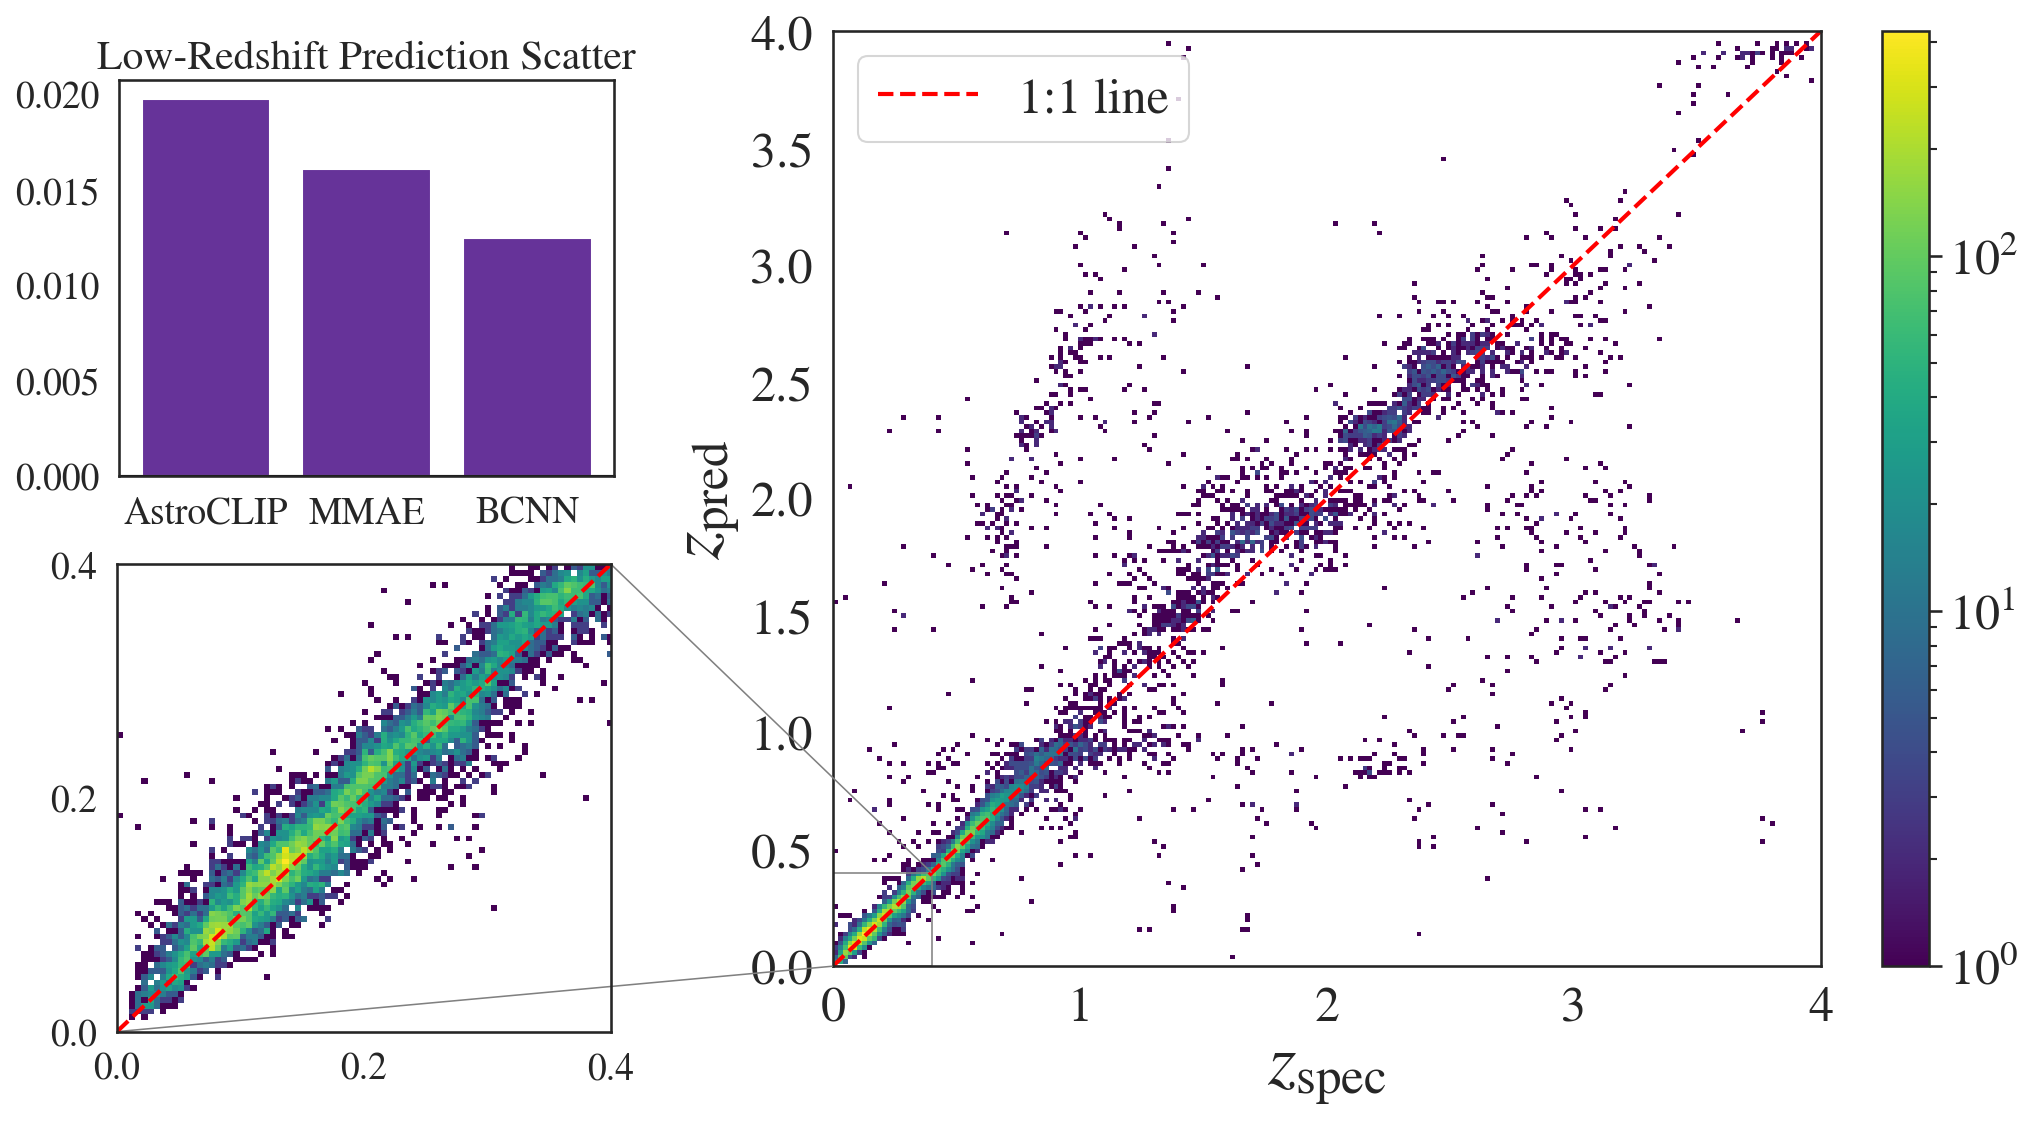

In [25]:
popout_plot_predictions(z_photo, z_spec, save_path="/path/to/save/image")